**To download and untar the dataset in colab:**

```bash
! mkdir -P /content/drive/MyDrive/datasets/deepsig
! wget -P /content/drive/MyDrive/datasets/deepsig https://f002.backblazeb2.com/file/deepsig-datasets/2016.10/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld
! mv /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
! tar -xvf /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2 -C /content/drive/MyDrive/datasets/deepsig/RML2016.10b
! rm /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
```

> Note : 
> The link will not work, you will have to request a link from the website.

# Imports and Constants

In [1]:
import pickle

import numpy as np
import scipy as sci
from scipy.integrate import cumulative_trapezoid

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gc

ROOT = '/kaggle/input/rml2016'
DAT = ROOT + '/RML2016.10b.dat'

# Loading and exploring the data

In [2]:
# from https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb
# modified for python 3
Xd = pickle.load(open(DAT, 'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
del Xd, snrs, mods
X = np.vstack(X)
y = np.array(lbl)
del lbl
gc.collect()

X.shape, y.shape

((1200000, 2, 128), (1200000, 2))

In [3]:
# The labels
print(f'{np.unique(y[:,0],return_counts=True)}\n\n\
{np.unique(y[:,1],return_counts=True)}')

(array(['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16',
       'QAM64', 'QPSK', 'WBFM'], dtype='<U21'), array([120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000,
       120000, 120000]))

(array(['-10', '-12', '-14', '-16', '-18', '-2', '-20', '-4', '-6', '-8',
       '0', '10', '12', '14', '16', '18', '2', '4', '6', '8'],
      dtype='<U21'), array([60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000,
       60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000,
       60000, 60000]))


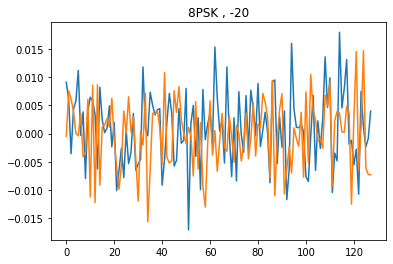

In [4]:
plt.plot(X[0,0])
plt.plot(X[0,1])
plt.title(f'{y[0,0]} , {y[0,1]}')
plt.show()

## Signal derivative

In [5]:
d_np = np.gradient(X[0,0])

lines=[d_np,X[0,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'derivative'))
fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Signal Integral

In [6]:
i_ct = cumulative_trapezoid(X[0,0])

lines=[i_ct,X[0,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'cumulative trapezoid'))

fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

# Creating Feature Spaces

Possible feature spaces:

1. raw signal
2. derivative
3. integration
4. raw and derivative
5. raw and integration
6. derivative and integration
7. raw and derivative and integration


In [7]:
'''X_diff = np.gradient(X,axis=-1)
X_int = np.zeros_like(X)
X_int[:,:,:-1] = np.array(cumulative_trapezoid(X))

X_raw_diff = np.concatenate((X,X_diff),axis=1)
X_raw_int = np.concatenate((X,X_int),axis=1)
X_diff_int = np.concatenate((X_diff,X_int),axis=1)

X_all = np.concatenate((X,X_diff,X_int),axis=1)

print(f'\
Shapes\n\
X_raw: {X.shape}\n\
X_diff: {X_diff.shape}\n\
X_int: {X_int.shape}\n\n\
X_raw_diff: {X_raw_diff.shape}\n\
X_raw_int: {X_raw_int.shape}\n\
X_diff_int: {X_diff_int.shape}\n\n\
X_all: {X_all.shape}')'''

"X_diff = np.gradient(X,axis=-1)\nX_int = np.zeros_like(X)\nX_int[:,:,:-1] = np.array(cumulative_trapezoid(X))\n\nX_raw_diff = np.concatenate((X,X_diff),axis=1)\nX_raw_int = np.concatenate((X,X_int),axis=1)\nX_diff_int = np.concatenate((X_diff,X_int),axis=1)\n\nX_all = np.concatenate((X,X_diff,X_int),axis=1)\n\nprint(f'Shapes\nX_raw: {X.shape}\nX_diff: {X_diff.shape}\nX_int: {X_int.shape}\n\nX_raw_diff: {X_raw_diff.shape}\nX_raw_int: {X_raw_int.shape}\nX_diff_int: {X_diff_int.shape}\n\nX_all: {X_all.shape}')"

In [8]:
'''del X_diff
del X_int

del X_raw_diff
del X_raw_int
del X_diff_int

del X_all'''

'del X_diff\ndel X_int\n\ndel X_raw_diff\ndel X_raw_int\ndel X_diff_int\n\ndel X_all'

# Data Splitting

In [9]:
def split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state =1, stratify = y[:,0])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.05, random_state =1, stratify = y_train[:,0])
    return x_train, x_val, x_test, y_train, y_val, y_test

# Models

## Hyperparameters

In [10]:
EPOCHS = 100
PATIENCE = 6
LEARNING_RATE = 0.0009

## CNN model
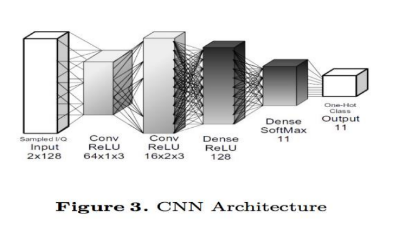

In [11]:
def create_cnn(name,cnn_input_shape):
    cnn_model = keras.Sequential([
        layers.Conv2D(64,
                    kernel_size=3,
                    activation='relu',
                      padding='same',
                    input_shape=cnn_input_shape),
        layers.Conv2D(16,
                     kernel_size=3,
                      strides=2,
                      padding='same',
                     activation='relu'),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(10,activation='softmax'),
    ],name=name)

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = keras.losses.CategoricalCrossentropy()
    cnn_model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

    print(cnn_model.summary())
    return cnn_model
    
# TODO: questions: 
# is it conv1D
# 1. Padding?
# 2. what is x1  and x2 in 2nd and 3rd layer? kernel size or number of Conv?

In [12]:
x = X
cnn_model = create_cnn("cnn_2_ch",x.shape[1:]+(1,))

2022-12-31 19:30:10.686761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 19:30:10.691629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 19:30:10.692659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 19:30:10.694802: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "cnn_2_ch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 128, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 64, 16)         9232      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 142,362
Trainable params: 142,362
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
values = np.linspace(0.00001,LEARNING_RATE,20)[::-1]
boundaries = np.linspace(5, 100,19)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = PATIENCE, mode='min')

def configure_checkpoints(path):
    return keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

In [14]:
def train_and_plot(model,checkpoint_path,x_train,y_train,x_val,y_val,epochs=EPOCHS):
    checkpoint = configure_checkpoints(checkpoint_path)
    history=model.fit(
        x=np.array(x_train),
        y=y_train,
        epochs=epochs,
        validation_data=(np.array(x_val),y_val),
        callbacks=[lr_scheduler,checkpoint,early_stopping]
    )

    num=len(history.history['loss'])

    plt.plot(range(num),history.history['loss'],label = 'training loss')
    plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

    plt.legend()

    plt.xlabel("Epochs ")
    plt.ylabel('Loss')

    plt.figure()

    plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
    plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

    plt.legend()
    plt.xlabel("Epochs ")
    return history

In [15]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [16]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

2022-12-31 19:30:17.367168: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 817152000 exceeds 10% of free system memory.
2022-12-31 19:30:18.340864: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 817152000 exceeds 10% of free system memory.
2022-12-31 19:30:19.021627: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).


2022-12-31 19:30:20.289547: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


24938/24938 [==============================] - 89s 3ms/step - loss: 1.4345 - accuracy: 0.4234 - val_loss: 1.2345 - val_accuracy: 0.4908
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 83s 3ms/step - loss: 1.2062 - accuracy: 0.5023 - val_loss: 1.1738 - val_accuracy: 0.5189
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 82s 3ms/step - loss: 1.1645 - accuracy: 0.5168 - val_loss: 1.1550 - val_accuracy: 0.5206
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 83s 3ms/step - loss: 1.1461 - accuracy: 0.5234 - val_loss: 1.1452 - val_accuracy: 0.5240
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtyp

[1.079214334487915, 0.5490238070487976]

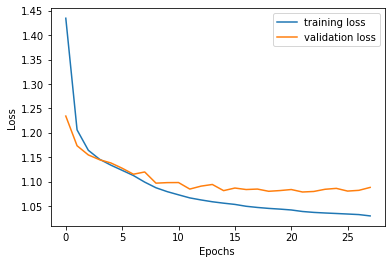

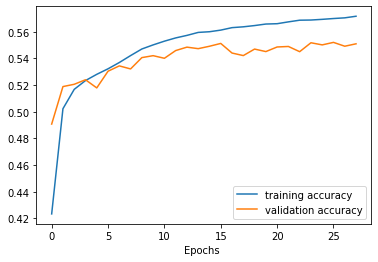

In [17]:
cnn_history = train_and_plot(
    cnn_model,
    "/kaggle/working/checkpoints/cnn",
    x_train.reshape(x_train.shape+(1,)),
    y_train_encoded,
    x_val.reshape(x_val.shape+(1,)),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train
cnn_model.load_weights("/kaggle/working/checkpoints/cnn")
cnn_model.evaluate(x_val.reshape(x_val.shape+(1,)),y_val_encoded)

In [18]:
# cnn_model.load_weights("/kaggle/working/checkpoints/cnn")
cnn_model.evaluate(x_val.reshape(x_val.shape+(1,)),y_val_encoded)

1313/1313 [==============================] - 4s 3ms/step - loss: 1.0792 - accuracy: 0.5490


[1.079214334487915, 0.5490238070487976]

## Test Results

In [19]:
def eval_model(model,x,y,y_encoded):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x.reshape(x.shape+(1,)))
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y_encoded,axis=-1)
    
    target_names = np.unique(y[:,0])
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_numbers, y_pred, target_names=target_names))
    
    cm = tf.math.confusion_matrix(y_numbers,y_pred).numpy().astype(np.int64)
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)
    sns.heatmap(cm,annot=True)
    plt.xticks(tick_marks, labels, rotation= 45)
    plt.yticks(tick_marks, labels, rotation=-45)
    
    plt.figure()
    snrs = np.unique(y[:,1])
    
    accuracies = np.zeros_like(snrs,dtype=np.float32)
    for i, snr in enumerate(snrs):
        idx = y[:,1] == snr
        cm = tf.math.confusion_matrix(y_numbers[idx],y_pred[idx]).numpy().astype(np.int64)
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)

        sns.heatmap(cm,annot=True)
        plt.title(f"SNR = {snr}")
        plt.xticks(tick_marks, labels, rotation= 45)
        plt.yticks(tick_marks, labels, rotation=-45)
        plt.show()
        plt.figure()
        accuracies[i] = np.count_nonzero(y_numbers[idx] == y_pred[idx]) / y_pred[idx].shape[0]
    
    plt.plot(snrs,np.around(accuracies * 100,2))
    plt.xlabel('SNR')
    plt.ylabel("Accuracy")
    plt.show()

2022-12-31 20:10:11.933102: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 368640000 exceeds 10% of free system memory.
2022-12-31 20:10:12.347634: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 368640000 exceeds 10% of free system memory.


              precision    recall  f1-score   support

        8PSK       0.48      0.52      0.50     36000
      AM-DSB       0.46      0.73      0.56     36000
        BPSK       0.61      0.62      0.62     36000
       CPFSK       0.60      0.63      0.62     36000
        GFSK       0.57      0.67      0.61     36000
        PAM4       0.82      0.69      0.75     36000
       QAM16       0.45      0.40      0.42     36000
       QAM64       0.54      0.34      0.42     36000
        QPSK       0.49      0.57      0.53     36000
        WBFM       0.54      0.28      0.37     36000

    accuracy                           0.55    360000
   macro avg       0.56      0.55      0.54    360000
weighted avg       0.56      0.55      0.54    360000



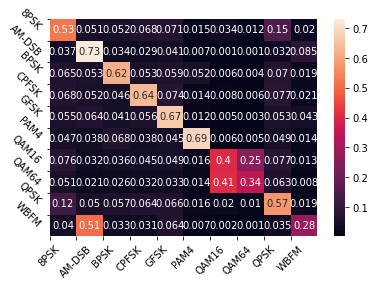

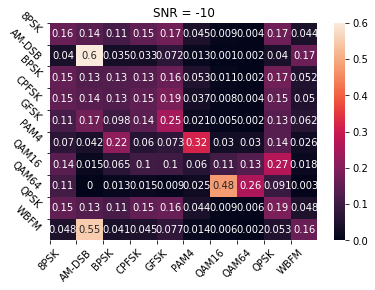

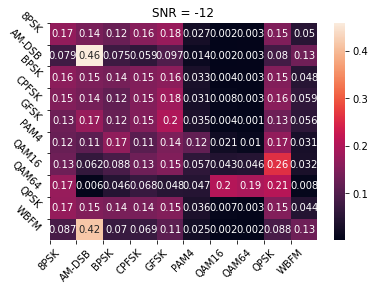

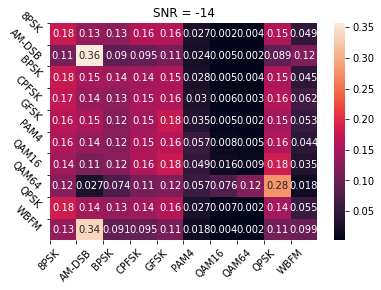

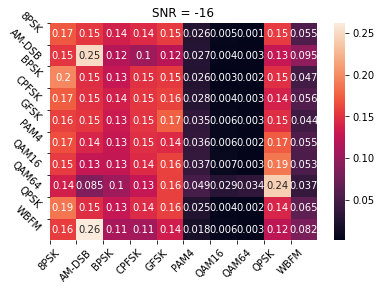

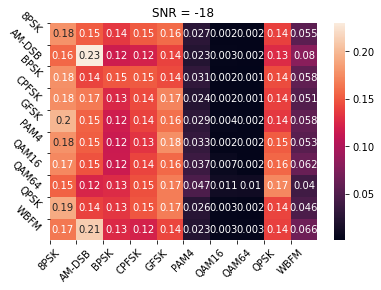

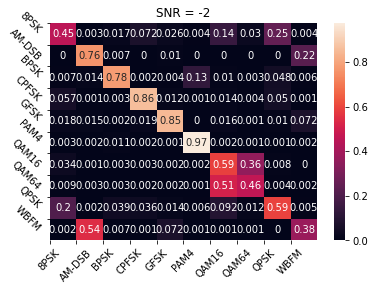

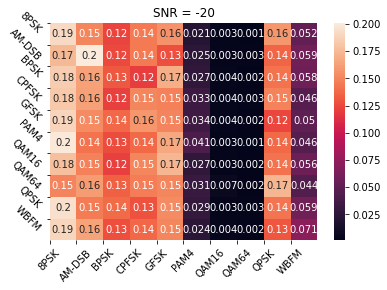

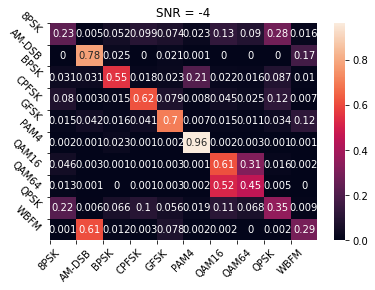

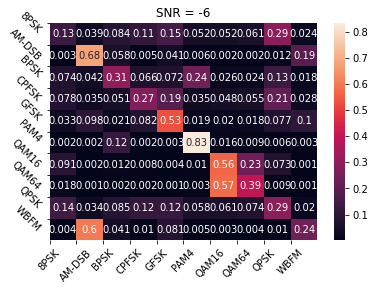

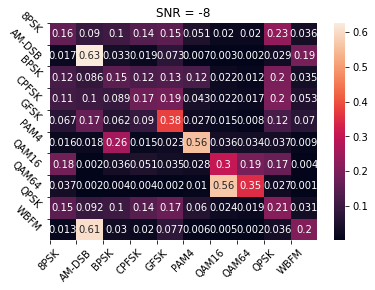

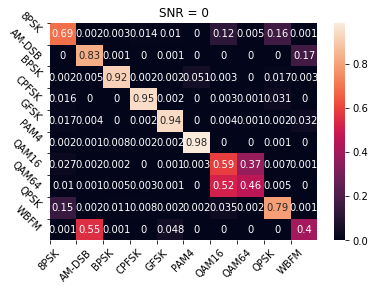

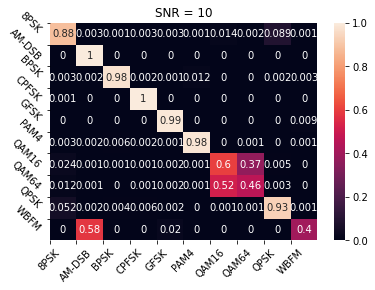

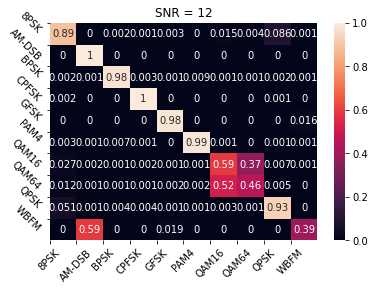

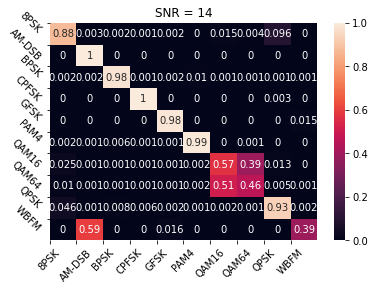

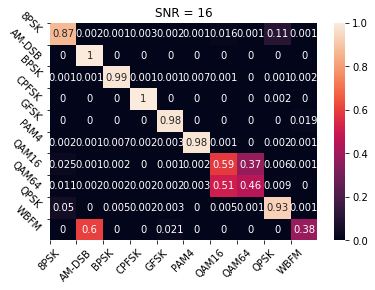

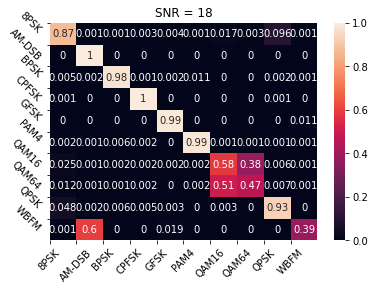

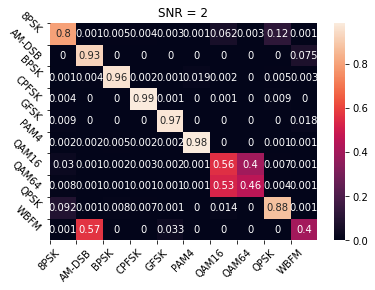

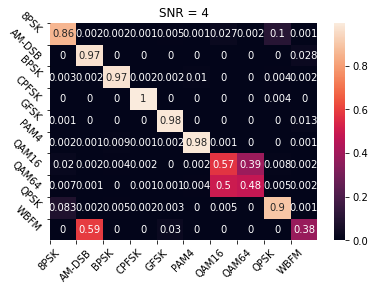

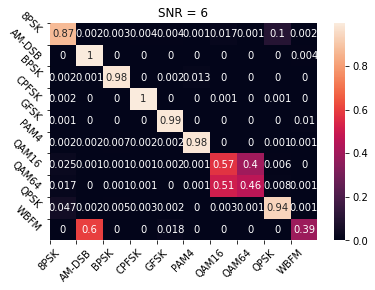

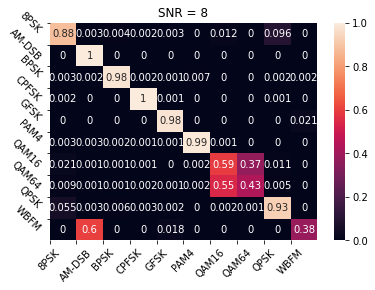

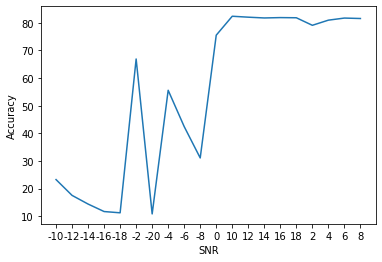

In [20]:
eval_model(cnn_model,x_test,y_test,y_test_encoded)

### CNN on X diff

In [21]:
x = np.gradient(X,axis=-1)
cnn_diff_model = create_cnn("cnn_diff",x.shape[1:]+(1,))

Model: "cnn_diff"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 2, 128, 64)        640       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 64, 16)         9232      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 142,362
Trainable params: 142,362
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

2022-12-31 20:11:13.561074: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 817152000 exceeds 10% of free system memory.


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 84s 3ms/step - loss: 2.3027 - accuracy: 0.0997 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 83s 3ms/step - loss: 2.3027 - accuracy: 0.1008 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 85s 3ms/step - loss: 2.3027 - accuracy: 0.0997 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 84s 3ms/step - loss: 2.3027 - accuracy: 0.0995 - val_loss: 2.3026 - val_accur

[2.302645206451416, 0.10000000149011612]

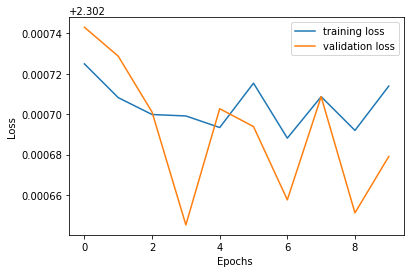

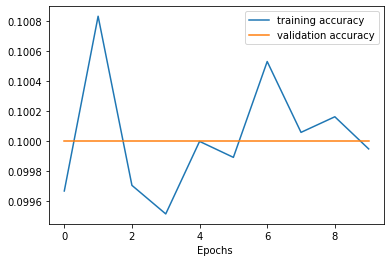

In [23]:
cnn_diff_history = train_and_plot(
    cnn_diff_model,
    "/kaggle/working/checkpoints/cnn",
    x_train.reshape(x_train.shape+(1,)),
    y_train_encoded,
    x_val.reshape(x_val.shape+(1,)),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

cnn_diff_model.load_weights("/kaggle/working/checkpoints/cnn")
cnn_diff_model.evaluate(x_val.reshape(x_val.shape+(1,)),y_val_encoded)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

        8PSK       0.00      0.00      0.00     36000
      AM-DSB       0.00      0.00      0.00     36000
        BPSK       0.00      0.00      0.00     36000
       CPFSK       0.00      0.00      0.00     36000
        GFSK       0.00      0.00      0.00     36000
        PAM4       0.00      0.00      0.00     36000
       QAM16       0.00      0.00      0.00     36000
       QAM64       0.00      0.00      0.00     36000
        QPSK       0.10      1.00      0.18     36000
        WBFM       0.00      0.00      0.00     36000

    accuracy                           0.10    360000
   macro avg       0.01      0.10      0.02    360000
weighted avg       0.01      0.10      0.02    360000



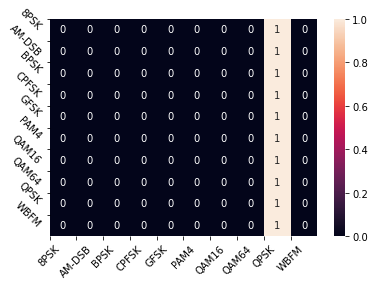

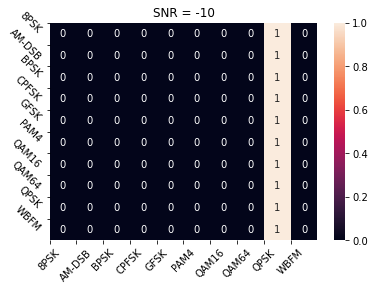

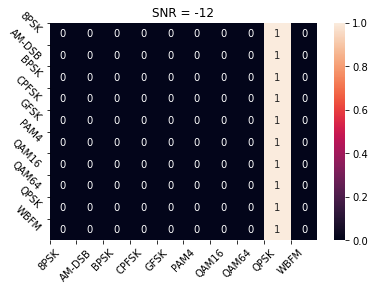

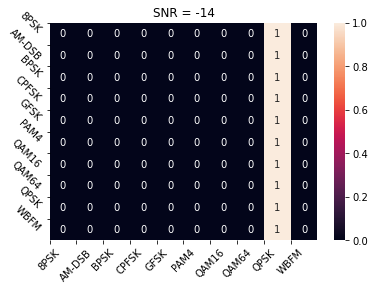

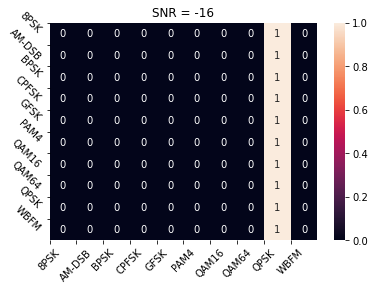

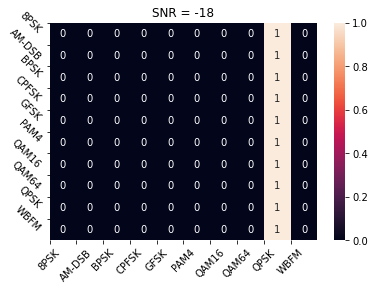

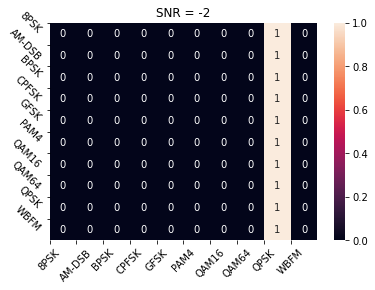

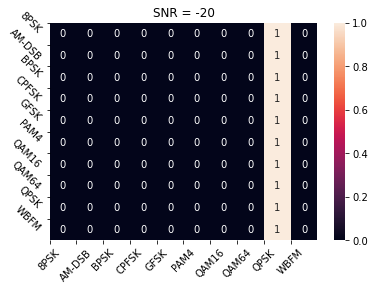

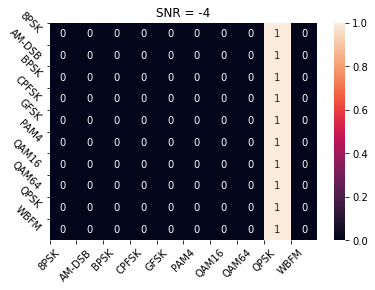

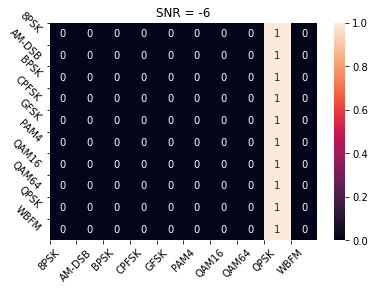

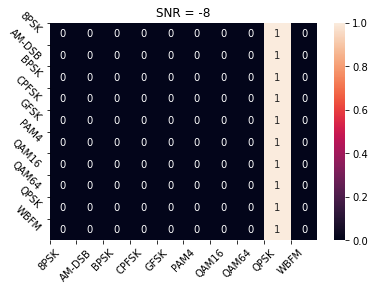

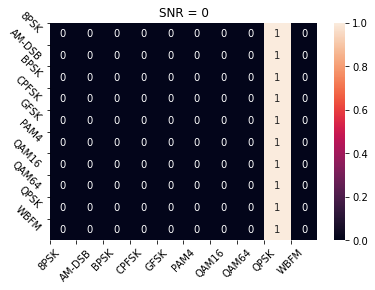

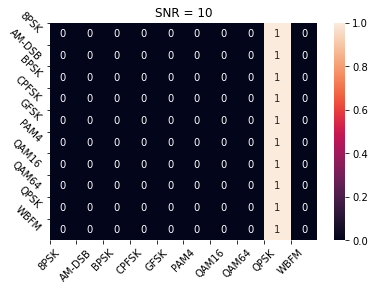

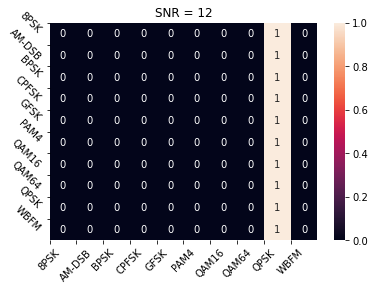

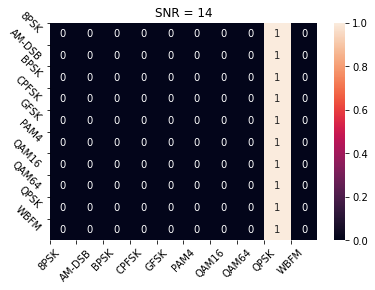

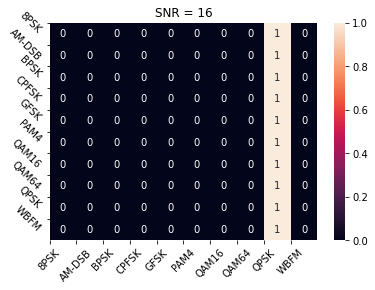

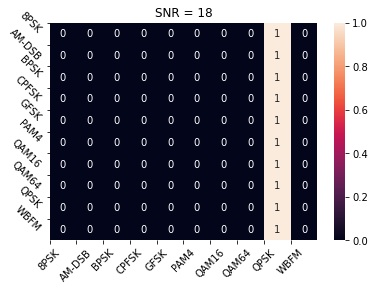

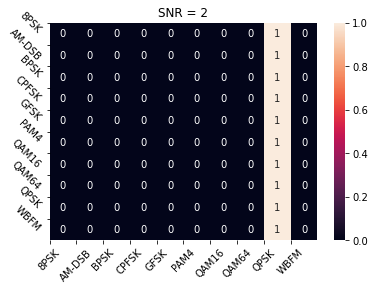

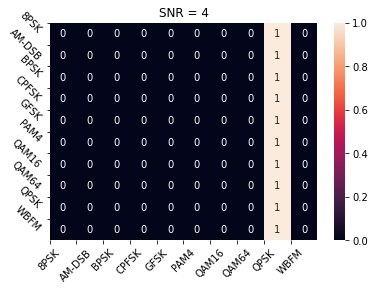

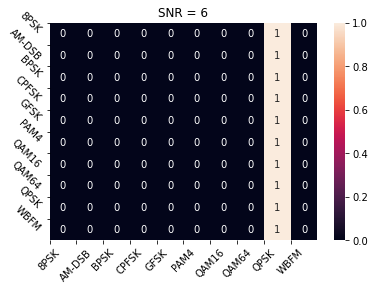

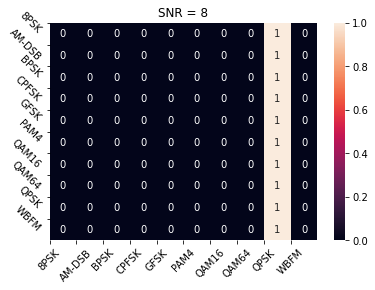

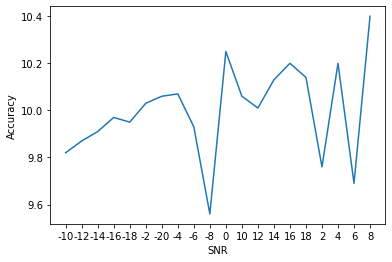

In [24]:
eval_model(cnn_diff_model,x_test,y_test,y_test_encoded)